# Bankruptcy Prediction Using Machine Learning
This notebook focuses on building a machine learning model to predict bankruptcy based on financial indicators.

## Import Libraries
Import essential libraries for data handling, visualization, and modeling.

In [1]:
# Import data manipulation libraries
import pandas as pd  # For data manipulation and analysis
import numpy as np   # For numerical operations
import seaborn as sns  # For statistical data visualization
import matplotlib.pyplot as plt  # For creating plots and visualizations
import plotly.express as px

# Import model selection and preprocessing tools
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.preprocessing import StandardScaler  # For standardizing features
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

# Import classification models
from sklearn.linear_model import LogisticRegression  # For logistic regression classification
from sklearn.linear_model import LinearRegression  # For linear regression (note: this is not for classification)
from sklearn.ensemble import RandomForestClassifier  # For random forest classification
from sklearn.neighbors import KNeighborsClassifier  # For k-nearest neighbors classification
from sklearn.svm import SVC  # For support vector classification

# Import evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, classification_report, confusion_matrix  # For model evaluation

## Load Dataset
Load the dataset and perform an initial inspection.

In [2]:
# Read the CSV file named "data.csv" into a pandas DataFrame
df = pd.read_csv("/content/sample_data/data.csv")
# Display the entire DataFrame
df


,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0.716845,0.009219,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0.795297,0.008323,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0.774670,0.040003,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0.739555,0.003252,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0.795016,0.003878,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0.799927,0.000466,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0.799748,0.001959,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0.797778,0.002840,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0.811808,0.002837,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


## Data Preprocessing
Clean the data, handle missing values, encode features if necessary.

In [3]:
# Check for missing values in the dataframe
# This prints the count of null values for each column
print(df.isnull().sum())


Bankrupt?                                                   0
 ROA(C) before interest and depreciation before interest    0
 ROA(A) before interest and % after tax                     0
 ROA(B) before interest and depreciation after tax          0
 Operating Gross Margin                                     0
                                                           ..
 Liability to Equity                                        0
 Degree of Financial Leverage (DFL)                         0
 Interest Coverage Ratio (Interest expense to EBIT)         0
 Net Income Flag                                            0
 Equity to Liability                                        0
Length: 96, dtype: int64


In [4]:
# Remove rows with any missing values (NaN) from the dataframe and modify the original dataframe
df.dropna(inplace=True)
df.shape

(6819, 96)

In [5]:
# Identify columns with all same values
cols_to_drop = [col for col in df.columns if df[col].nunique() == 1]

# Drop the identified columns
df = df.drop(columns=cols_to_drop)
df.shape


(6819, 95)

## Visualisation of Data and it's features

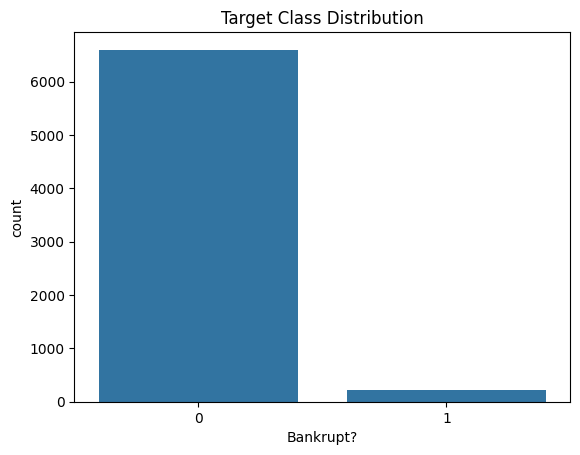

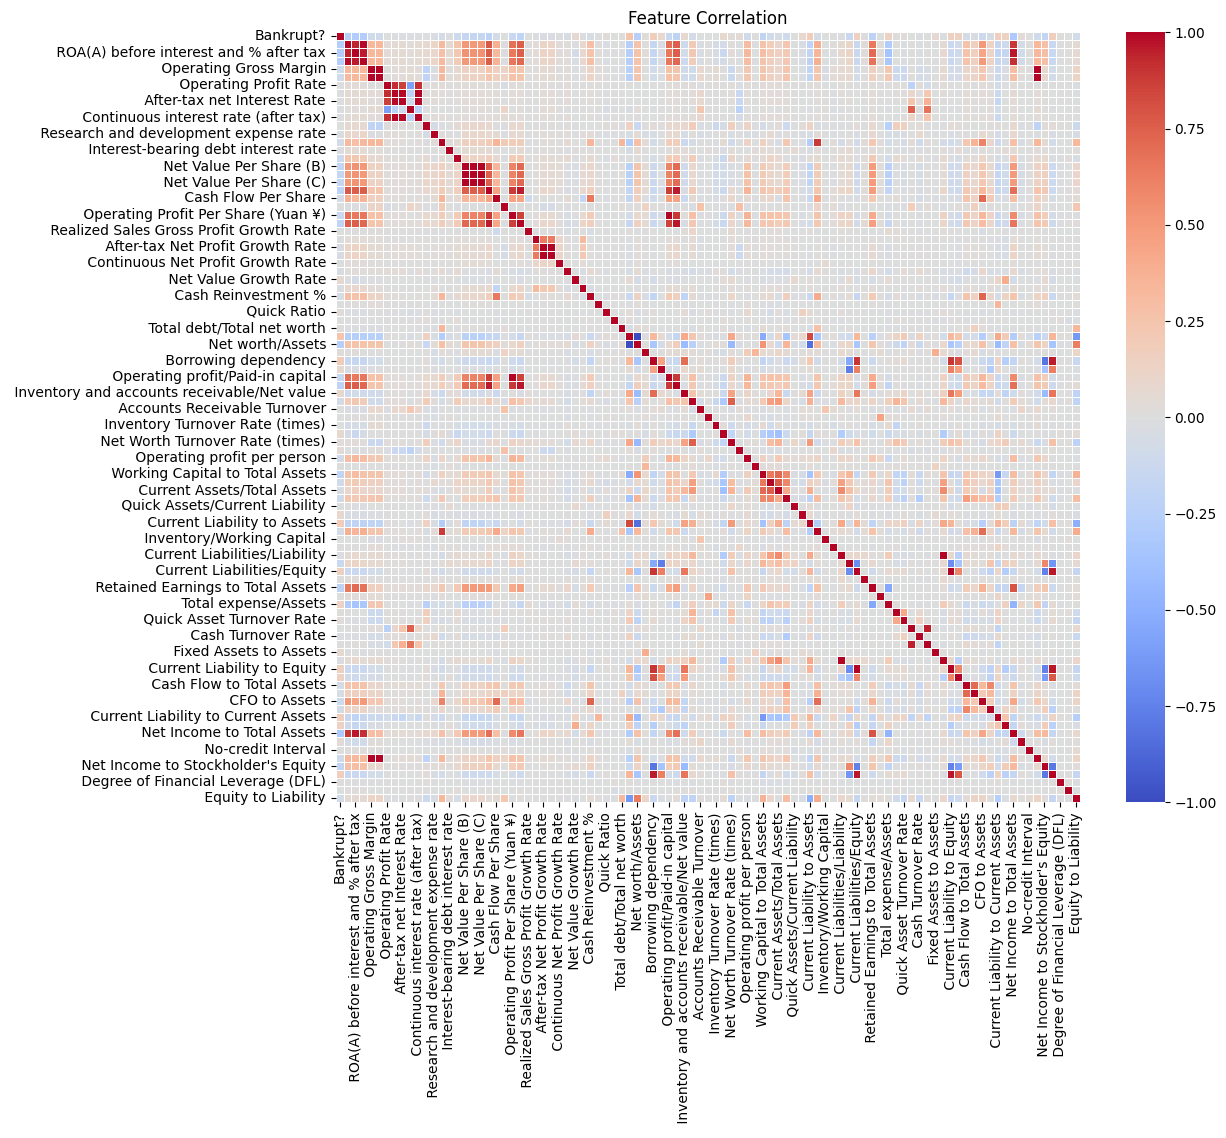

In [6]:
# Create a count plot to visualize the distribution of the target variable 'Bankrupt?'
sns.countplot(data=df, x='Bankrupt?')
plt.title("Target Class Distribution")
plt.show()

# Create a larger figure for better readability of the correlation matrix
plt.figure(figsize=(12, 10))
# Generate a heatmap showing correlations between all features
# Using coolwarm color palette and adding thin lines between cells
sns.heatmap(df.corr(), cmap="coolwarm", linewidths=0.5)
plt.title("Feature Correlation")
plt.show()


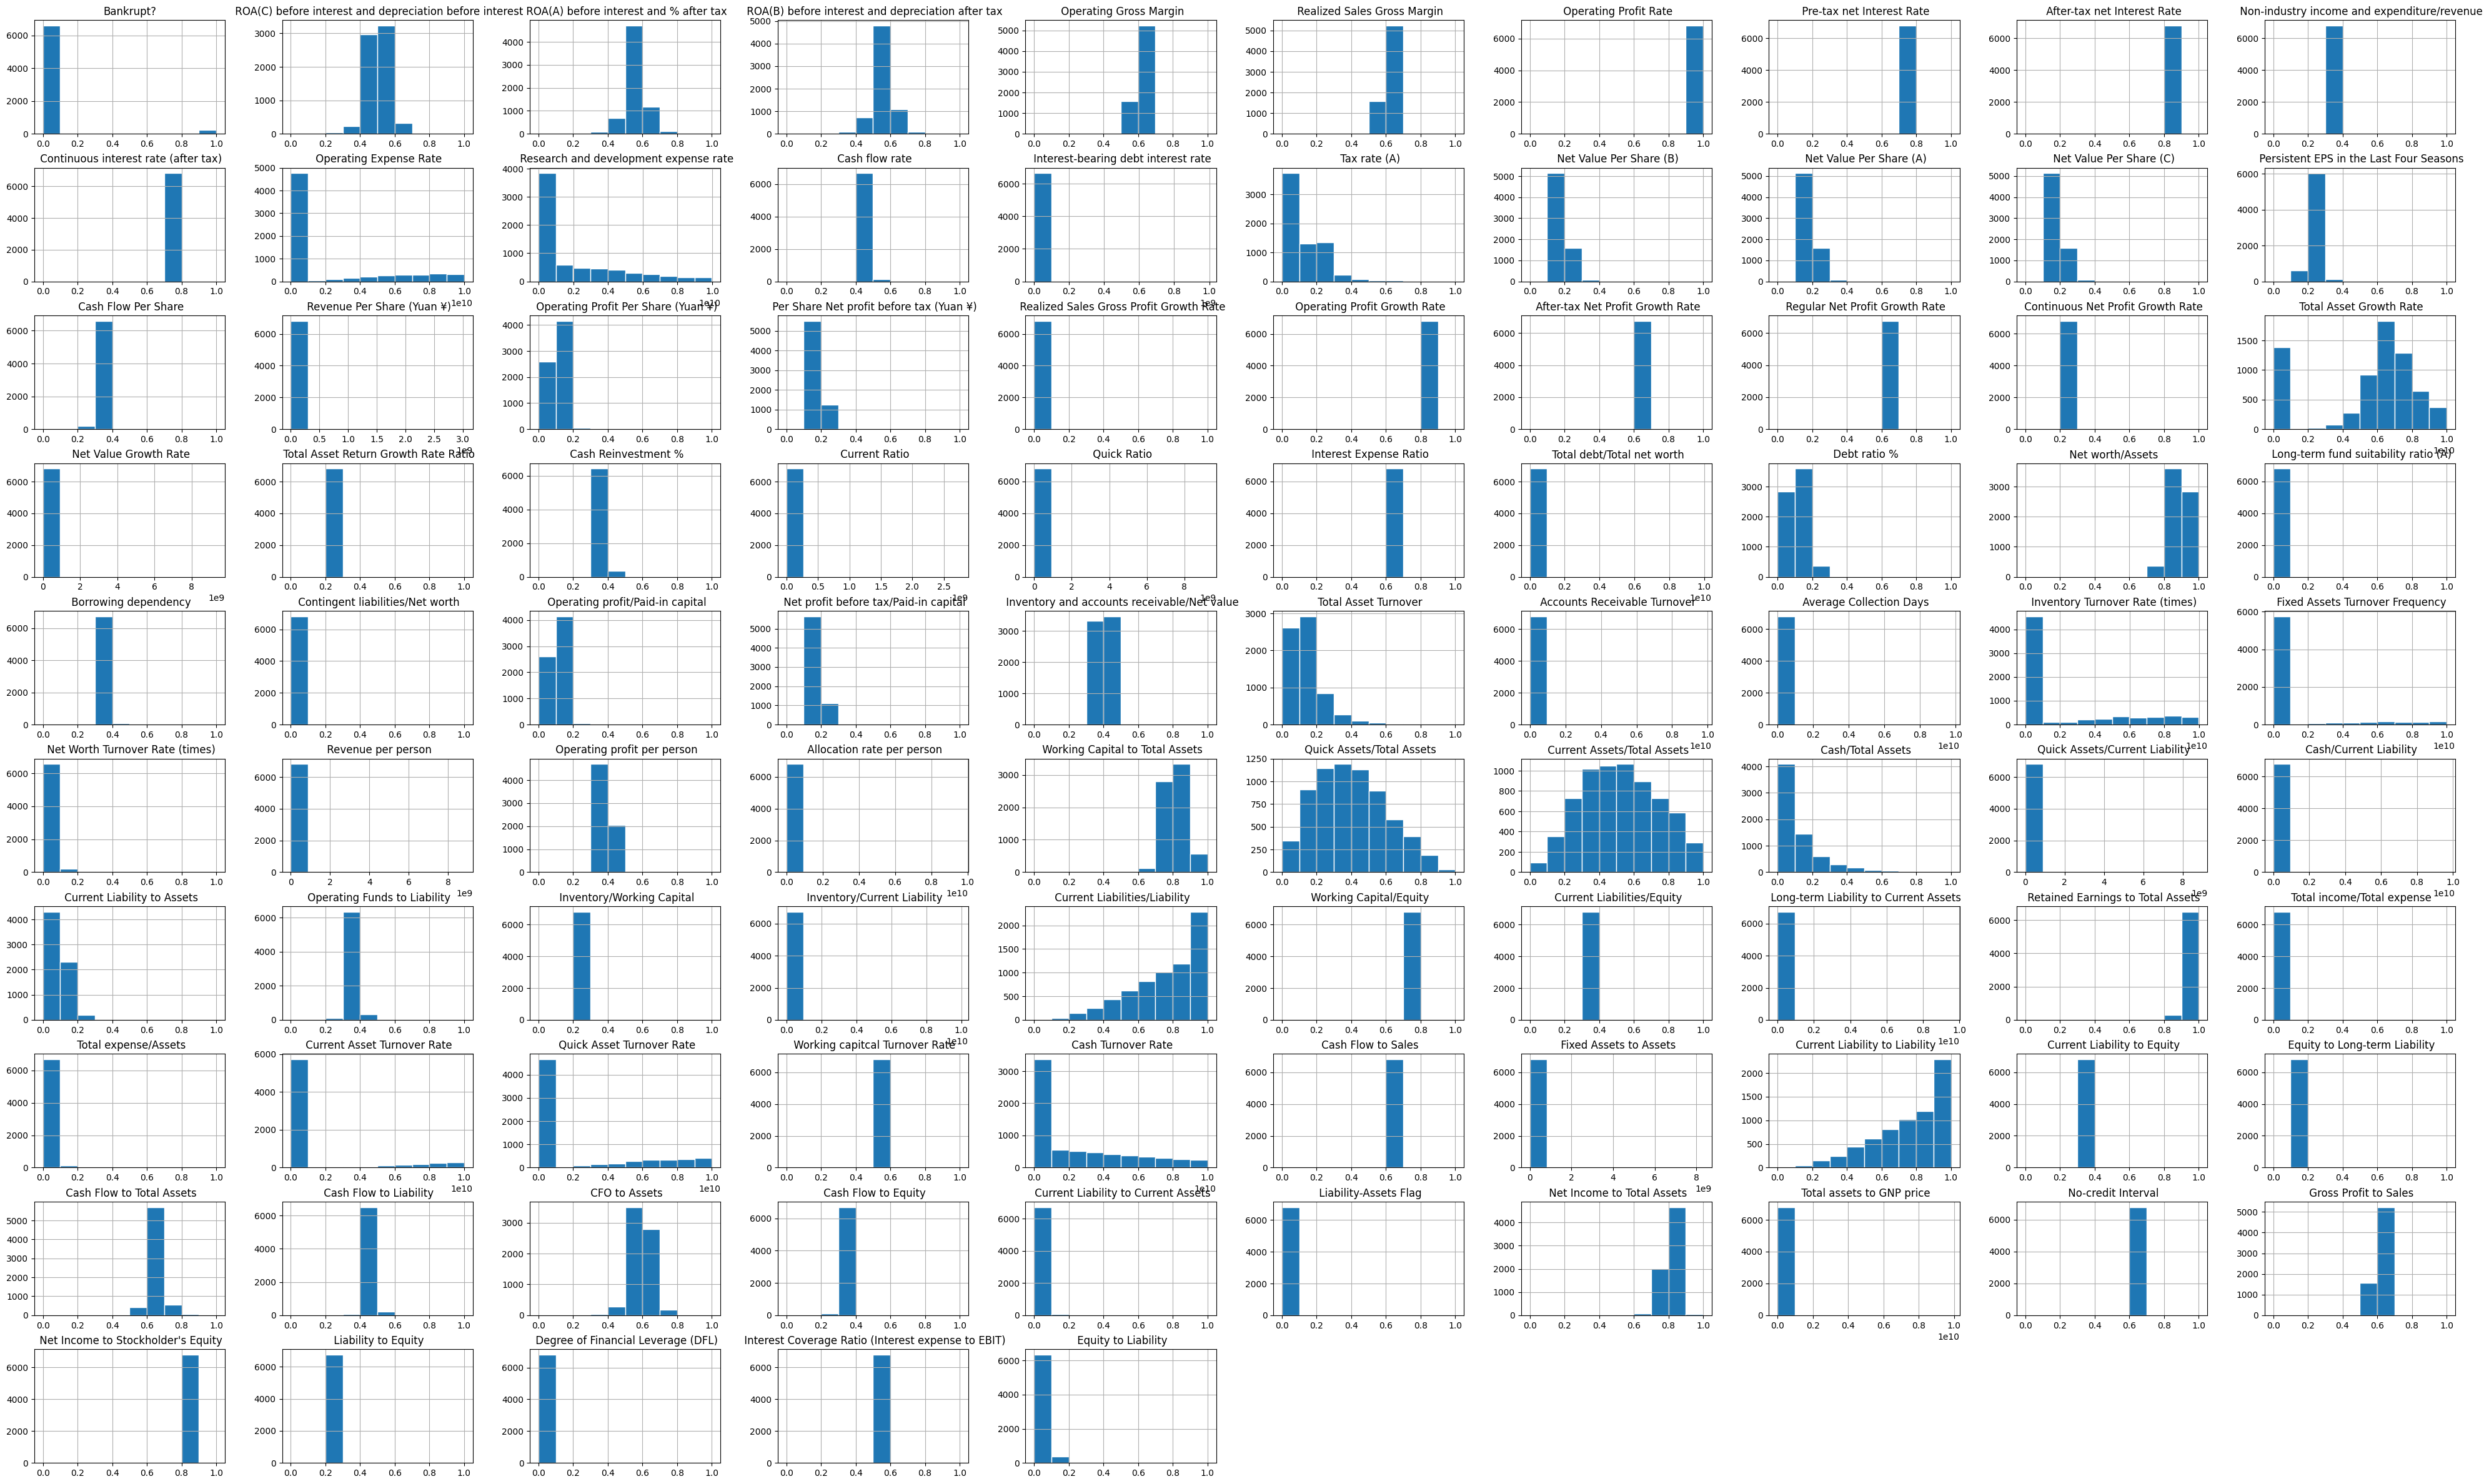

In [7]:
df.hist(figsize=(50,30), edgecolor = 'white')
plt.show()

## Model Building
Train machine learning models to classify whether a company will go bankrupt.

### Splitting Dataset
Split the dataset into training and testing sets for evaluation.

In [8]:
def preprocess_inputs(df):
    """
    Preprocesses input dataframe for machine learning by splitting into features and target,
    creating train/test sets, and applying standardization.

    Args:
        df: Pandas DataFrame containing the dataset with 'Bankrupt?' column as target

    Returns:
        X_train: Standardized training features
        X_test: Standardized test features
        y_train: Training target values
        y_test: Test target values
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = df.copy()

    # Split df into X and y
    y = df['Bankrupt?']  # Target variable
    X = df.drop('Bankrupt?', axis=1)  # Feature variables

    # Train-test split with 70% training data, ensuring reproducibility with random_state
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, shuffle=True, random_state=1)

    # Scale X using StandardScaler to normalize features (mean=0, std=1)
    scaler = StandardScaler()
    scaler.fit(X_train)  # Fit scaler on training data only to prevent data leakage

    # Transform both training and test data, preserving DataFrame format with original indices and column names
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

    return X_train, X_test, y_train, y_test

In [9]:
# Split the dataset into training and testing sets using the preprocess_inputs function
# X_train and X_test contain the feature variables
# y_train and y_test contain the target variables
X_train, X_test, y_train, y_test = preprocess_inputs(df)


In [10]:
X_train

,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,Continuous interest rate (after tax),...,Liability-Assets Flag,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Equity to Liability
3392,-7.065972,-7.189713,-7.577832,-0.353178,-0.352216,-27.422519,-9.852867,-9.473508,0.174600,-17.488805,...,-0.032383,-9.998552,4.692638,-0.014135,-0.353225,-1.832779,-0.140534,-0.046856,-0.002980,-0.193823
2755,0.405365,0.354931,0.313557,0.203699,0.200630,0.105921,0.077435,0.062927,0.047214,0.099756,...,-0.032383,0.400919,-0.053114,-0.022182,0.203712,0.096787,-0.171572,-0.042981,0.019996,-0.101423
4442,1.063045,1.174855,1.177379,1.634667,1.635325,0.255679,0.096169,0.093795,0.003669,0.157860,...,-0.032383,1.167791,-0.053114,-0.015673,1.634904,0.195891,-0.260642,-0.046222,0.000988,0.460305
4267,-0.503014,-0.324003,-0.454382,-0.296140,-0.283111,-0.186523,0.016814,0.015052,0.103257,0.012236,...,-0.032383,-0.263996,-0.053114,-0.056605,-0.296136,-0.020661,-0.118012,0.026918,0.200834,-0.246507
4912,-0.145685,-0.062164,-0.098122,-0.707418,-0.706759,0.011218,0.016078,0.022094,0.014597,0.026255,...,-0.032383,-0.051356,-0.053114,0.054243,-0.707358,0.030413,0.028918,-0.031311,0.074381,-0.443493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
905,-0.121267,-0.052933,-0.160577,0.396829,0.383409,0.062863,0.032879,0.031040,0.012131,0.041490,...,-0.032383,0.058626,-0.053114,-0.019407,0.396914,0.038720,-0.145246,-0.044050,0.013951,-0.181453
5192,0.353272,0.448925,0.380411,-0.302144,-0.300137,0.053898,0.025100,0.027851,0.006583,0.035737,...,-0.032383,0.397778,-0.053114,-0.008254,-0.301900,0.157339,0.139915,-0.045442,0.005757,-0.516740
3980,0.306876,0.274365,0.367216,0.887161,0.889183,0.157314,0.047838,0.052564,-0.011575,0.080793,...,-0.032383,0.345919,-0.053114,0.011347,0.887037,0.072415,-0.252116,-0.046724,-0.002147,0.369173
235,-2.245702,-2.479975,-2.445042,-0.393706,-0.392779,-0.223142,-0.136463,-0.126225,-0.067057,-0.233955,...,-0.032383,-2.361698,-0.053114,-0.031286,-0.393747,-0.800755,0.524917,-0.051040,-0.031559,-0.629681


### Model Evaluation
Evaluate models using accuracy, confusion matrix, and classification reports.

In [11]:
def evaluate_model(model, name):
    # Train the model on the training data
    model.fit(X_train, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Print the model name and evaluation metrics
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))  # Percentage of correct predictions
    print("Precision:", precision_score(y_test, y_pred))  # Ratio of true positives to all predicted positives
    print("Recall:", recall_score(y_test, y_pred))  # Ratio of true positives to all actual positives
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))  # Area under the ROC curve
    print(classification_report(y_test, y_pred))  # Detailed classification metrics

# Initialize and evaluate a Logistic Regression model
lr = LogisticRegression()
evaluate_model(lr, "Logistic Regression")

# Initialize and evaluate a Random Forest model
rf = RandomForestClassifier()
evaluate_model(rf, "Random Forest")

# Initialize and evaluate a Support Vector Machine model
# probability=True enables probability estimates for ROC-AUC calculation
svm = SVC(probability=True)
evaluate_model(svm, "Support Vector Machine")

# Initialize and evaluate a K-Nearest Neighbors model
knn = KNeighborsClassifier()
evaluate_model(knn , "K-Nearest Neighbors")


Logistic Regression Evaluation:
Accuracy: 0.9648093841642229
Precision: 0.4782608695652174
Recall: 0.15492957746478872
ROC-AUC: 0.5744268140488501
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1975
           1       0.48      0.15      0.23        71

    accuracy                           0.96      2046
   macro avg       0.72      0.57      0.61      2046
weighted avg       0.95      0.96      0.96      2046


Random Forest Evaluation:
Accuracy: 0.967741935483871
Precision: 0.631578947368421
Recall: 0.16901408450704225
ROC-AUC: 0.5827348903547869
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1975
           1       0.63      0.17      0.27        71

    accuracy                           0.97      2046
   macro avg       0.80      0.58      0.63      2046
weighted avg       0.96      0.97      0.96      2046


Support Vector Machine Evaluation:
Accuracy: 0.9657869012

In [12]:
# Dictionary of classification models to evaluate
results = []
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                         Random Forest": RandomForestClassifier(),
}

# Loop through each model to train and evaluate
for name, model in models.items():
    # First fit (train) the model on training data
    model.fit(X_train, y_train)

    # Now we can score the model on test data
    y_pred = model.predict(X_test)
    # Calculate accuracy score by comparing predictions to actual values
    result = accuracy_score(y_test,y_pred)
    # Store the accuracy result for later comparison
    results.append(result)
    # Print the model name and its accuracy percentage
    print(name + ": {:.2f}%".format(result * 100))

                   Logistic Regression: 96.48%
                   K-Nearest Neighbors: 96.48%
   Support Vector Machine (RBF Kernel): 96.58%
                         Random Forest: 96.53%


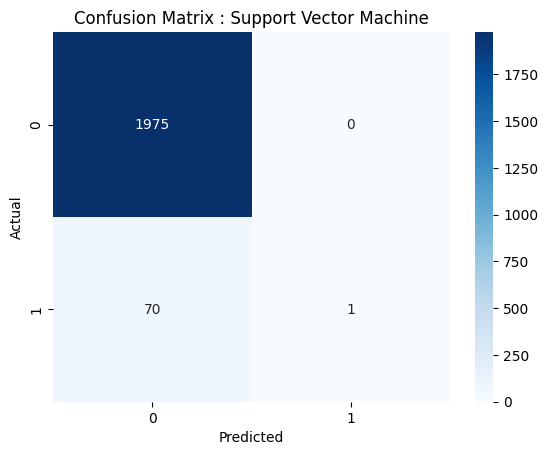

In [13]:
def Model_Accuracy(model, name):
    # Generate predictions using the provided model on the test data
    y_pred = model.predict(X_test)

    # Create a confusion matrix to evaluate model performance
    # This shows true positives, false positives, true negatives, and false negatives
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Visualize the confusion matrix as a heatmap for better readability
    # annot=True shows the values in each cell, fmt='d' formats them as integers
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')

    # Add title and labels to the confusion matrix plot
    plt.title("Confusion Matrix : " + name)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

    # Display the confusion matrix visualization
    plt.show()

# Call the function to evaluate and visualize the Support Vector Machine model's performance because it has the highest accuracy
Model_Accuracy(svm, "Support Vector Machine")

## Dimensionality Reduction (PCA)

****

In [14]:
n_components = 40

pca = PCA(n_components=n_components)
pca.fit(X_train)

X_train_reduced = pd.DataFrame(pca.transform(X_train), index=X_train.index, columns=["PC" + str(i) for i in range(1, n_components + 1)])
X_test_reduced = pd.DataFrame(pca.transform(X_test), index=X_test.index, columns=["PC" + str(i) for i in range(1, n_components + 1)])

In [15]:
fig = px.bar(
    x=["PC" + str(i) for i in range(1, n_components + 1)],
    y=pca.explained_variance_ratio_,
    labels={'x': "Principal Component", 'y': "Variance Ratio"},
    color=pca.explained_variance_ratio_,
    color_continuous_scale=[(0, 'lightblue'), (1, 'darkblue')],
    title="Proportion of Variance in Principal Components"
)

fig.show()

## Model Building for reduced data

In [16]:
def evaluate_model_reduced(model, name):
    # Train the model on the training data
    model.fit(X_train_reduced, y_train)
    # Make predictions on the test data
    y_pred = model.predict(X_test_reduced)

    # Print the model name and evaluation metrics
    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_test, y_pred))  # Percentage of correct predictions
    print("Precision:", precision_score(y_test, y_pred))  # Ratio of true positives to all predicted positives
    print("Recall:", recall_score(y_test, y_pred))  # Ratio of true positives to all actual positives
    print("ROC-AUC:", roc_auc_score(y_test, y_pred))  # Area under the ROC curve
    print(classification_report(y_test, y_pred))  # Detailed classification metrics

# Initialize and evaluate a Logistic Regression model
lr = LogisticRegression()
evaluate_model_reduced(lr, "Logistic Regression")

# Initialize and evaluate a Random Forest model
rf = RandomForestClassifier()
evaluate_model_reduced(rf, "Random Forest")

# Initialize and evaluate a Support Vector Machine model
# probability=True enables probability estimates for ROC-AUC calculation
svm = SVC(probability=True)
evaluate_model_reduced(svm, "Support Vector Machine")

# Initialize and evaluate a K-Nearest Neighbors model
knn = KNeighborsClassifier()
evaluate_model_reduced(knn , "K-Nearest Neighbors")


Logistic Regression Evaluation:
Accuracy: 0.9628543499511242
Precision: 0.4
Recall: 0.14084507042253522
ROC-AUC: 0.5666250668568372
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1975
           1       0.40      0.14      0.21        71

    accuracy                           0.96      2046
   macro avg       0.68      0.57      0.59      2046
weighted avg       0.95      0.96      0.95      2046


Random Forest Evaluation:
Accuracy: 0.9643206256109482
Precision: 0.25
Recall: 0.014084507042253521
ROC-AUC: 0.5062827598502407
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1975
           1       0.25      0.01      0.03        71

    accuracy                           0.96      2046
   macro avg       0.61      0.51      0.50      2046
weighted avg       0.94      0.96      0.95      2046


Support Vector Machine Evaluation:
Accuracy: 0.966275659824047
Precision: 1.0
Recal

### Model Evaluation for reduced data

In [17]:
reduced_results = []

# Loop through each model to train and evaluate
for name, model in models.items():
    # First fit (train) the model on training data
    model.fit(X_train_reduced, y_train)

    y_pred = model.predict(X_test_reduced)

    # Calculate accuracy score by comparing predictions to actual values
    result = accuracy_score(y_test, y_pred)
    # Store the accuracy result for later comparison
    reduced_results.append(result)
    # Print the model name and its accuracy percentage
    print(name + ": {:.2f}%".format(result * 100))

                   Logistic Regression: 96.29%
                   K-Nearest Neighbors: 96.43%
   Support Vector Machine (RBF Kernel): 96.63%
                         Random Forest: 96.48%


## Change in Performance After PCA

In [18]:
fig = px.bar(
    x=np.subtract(reduced_results, results),
    y=models.keys(),
    orientation='h',
    labels={'x': "Change in Performance", 'y': "Model"},
    color=np.subtract(reduced_results, results),
    color_continuous_scale=[(0, 'red'), (1, 'blue')],
    title="Change in Model Performance After Dimensionality Reduction"
)

fig.show()

In [21]:
# Train a Random Forest Classifier
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Get and print feature importances from Random Forest
print("Random Forest Feature Importances (Top 10):")
rf_feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(rf_feature_importances.head(10))

# Train a Logistic Regression model
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)

# Get and print coefficients (absolute values) from Logistic Regression
print("\nLogistic Regression Coefficients (Absolute, Top 10):")
lr_coefficients = pd.Series(lr_model.coef_[0], index=X_train.columns).abs().sort_values(ascending=False)
print(lr_coefficients.head(10))

Random Forest Feature Importances (Top 10):
Persistent EPS in the Last Four Seasons               0.032859
Net Value Growth Rate                                 0.032714
Net Income to Stockholder's Equity                    0.030905
Cash/Total Assets                                     0.025593
Per Share Net profit before tax (Yuan ¥)              0.025408
Equity to Liability                                   0.024590
Net profit before tax/Paid-in capital                 0.024421
Net Value Per Share (C)                               0.023881
Degree of Financial Leverage (DFL)                    0.023091
Interest Coverage Ratio (Interest expense to EBIT)    0.022000
dtype: float64

Logistic Regression Coefficients (Absolute, Top 10):
Liability to Equity                        1.012835
Persistent EPS in the Last Four Seasons    1.008890
Borrowing dependency                       0.961592
Accounts Receivable Turnover               0.811168
Cash/Total Assets                          0.7990

## Conclusion

 1. This notebook explored the task of bankruptcy prediction using various machine learning models.

 2. After loading and preprocessing the financial data, several classifiers were trained and evaluated.

 3. The models assessed included Logistic Regression, Random Forest, Support Vector Machine, and K-Nearest Neighbors.

 4. Evaluation metrics such as accuracy, precision, recall, and ROC-AUC were used to gauge performance.

 5. Additionally, dimensionality reduction using Principal Component Analysis (PCA) was applied to understand its impact on model performance and potentially reduce computational complexity.

 6. The confusion matrix for the best-performing model (Support Vector Machine) was visualized to provide a detailed breakdown of true positives, false positives, true negatives, and false negatives.

 7. The change in accuracy for each model after applying PCA was analyzed to determine if dimensionality reduction improved or hindered their predictive capabilities on this dataset.

 8. The results indicated that some models showed slight improvements in accuracy after PCA, while others saw a minor decrease, suggesting that the original feature set contained useful information that PCA partially discarded, or that
 the dimensionality reduction helped in handling potential noise or multicollinearity for certain algorithms.

 9. Finally, Based on the analysis of feature importances from the Random Forest Classifier and coefficients from the Logistic Regression model, features appear to be most responsible for bankruptcy prediction
 are printed.